In [169]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
%matplotlib inline

In [170]:
tf.__version__

'1.2.1'


### Configuration of Neural Network
The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [171]:

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## load data

In [172]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [173]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [174]:
# The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. 
#The index of this one element is the class-number, that is, the digit shown in the associated image. 
#We also need the class-numbers as integers for the test-set, so we calculate it now.
print("The test data looks like:\n{}\n".format(data.test.labels))
data.test.cls = np.argmax(data.test.labels, axis = 1)
print("Test data after converting one-hot to class:\n{}\n".format(data.test.cls))

print("Image dimension is {}\n".format(data.test.images[0].shape))
print("one test image looks like:\n{}.\n".format(data.test.images[0]))

The test data looks like:
[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Test data after converting one-hot to class:
[7 2 1 ..., 4 5 6]

Image dimension is (784,)

one test image looks like:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          

In [175]:
#Data Dimension
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [176]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plot.
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        #show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
        

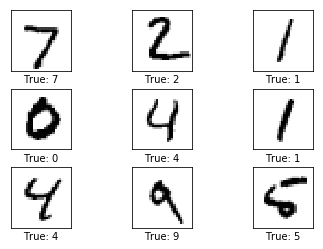

In [177]:
#plot the data
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true = cls_true)

### 1. Placeholder variables used for inputting data to the graph.

### 2. Variables that are going to be optimized so as to make the convolutional network perform better.
### 3.The mathematical formulas for the convolutional network.
### 4. A cost measure that can be used to guide the optimization of the variables.
### 5. An optimization method which updates the variables.

In [178]:
#Functions for creating new TensorFlow variables in the given shape and initializing them with random values. 
#Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape = [length]))

### Helper function to create a new convolutional layer
It is assumed that the input is a 4-dim tensor with the following dimensions:
1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.
The output is another 4-dim tensor with the following dimensions:
1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [179]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling = True):
    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    #create new weights aka. filters with the given shape
    weights = new_weights(shape = shape)
    
    #crate new biases, one fo each filter
    biases = new_biases(length = num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides = [1, 1, 1, 1],
                        padding = 'SAME')
    
    
    #Add the biases to the results of the convolution.
    #A biase-value is added to each filter-channel
    layer += biases
    
    #Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value = layer, ksize = [1, 2, 2, 1],
                              strides = [1, 2, 2, 1], padding = 'SAME')
  
    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later
    
    return layer, weights

### Helper function for flattening a layer
A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [180]:
def flatten_layer(layer):
    #Get the shape of the input layer
    layer_shape = layer.get_shape()
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()

    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features
    
    

### Helper-function for creating a new Fully-Connected Layer

This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.
It is assumed that the input is a 2-dim tensor of shape [num_images, num_inputs]. The output is a 2-dim tensor of shape [num_images, num_outputs].

In [181]:
def new_fc_layer(input, #from previous layer
                num_inputs, # Num. inputs from previous layer
                num_outputs, # Num outputs,
                use_relu=True): #Use rectified linear Unit
    #create new weights and biases.
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.
First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

In [182]:
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name = 'x')


The convolutional layers expect x to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead [num_images, img_height, img_width, num_channels]. Note that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [183]:
x_image = tf.reshape(x, shape = [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [184]:
y_true = tf.placeholder(tf.float32, shape = [None, num_classes], name = 'y_true')
y_true_cls = tf.argmax(y_true, dimension = 1)

### Convolutional Layer 1
Create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling

In [185]:
layer_conv1, weights_conv1 = new_conv_layer(input = x_image,
                                           num_input_channels = num_channels,
                                           filter_size = filter_size1,
                                           num_filters = num_filters1,
                                           use_pooling = True)

Check the shape of the tensor that will be output by the convolutional layer. It is (?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?), each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.

In [186]:
layer_conv1

<tf.Tensor 'Relu_8:0' shape=(?, 14, 14, 16) dtype=float32>

Convolutional Layer 2
Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [187]:
layer_conv2, weights_conv2 = new_conv_layer(input = layer_conv1,
                                           num_input_channels = num_filters1,
                                           filter_size = filter_size2,
                                           num_filters = num_filters2,
                                           use_pooling = True)

In [188]:
layer_conv2

<tf.Tensor 'Relu_9:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer
The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors

In [189]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_10:0' shape=(?, 1764) dtype=float32>

### Fully-Connected Layer 1
Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [190]:
layer_fcl = new_fc_layer(input = layer_flat, 
                        num_inputs = num_features,
                        num_outputs = fc_size,
                        use_relu = True)

In [191]:
layer_fcl

<tf.Tensor 'Relu_10:0' shape=(?, 128) dtype=float32>


### Fully-Connected Layer 2
Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [192]:
layer_fc2 = new_fc_layer(input = layer_fcl,
                        num_inputs = fc_size,
                        num_outputs = num_classes,
                        use_relu = False)

In [193]:
layer_fc2

<tf.Tensor 'add_12:0' shape=(?, 10) dtype=float32>

### Predicted Class
The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred

In [194]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension = 1)
y_pred_cls

<tf.Tensor 'ArgMax_7:0' shape=(?,) dtype=int64>

Cost-function to be optimized
To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.
The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.
TensorFlow has a built-in function for calculating the cross-entropy. Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied. $$ -\sum_i y_i * log y_i $$

In [195]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                       labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [196]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method
Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent.
Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [197]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures
We need a few more performance measures to display the progress to the user.
This is a vector of booleans whether the predicted class equals the true class of each image

In [198]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [199]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### TensorFlow Run
### Create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [200]:
session = tf.Session()

### Initialzie variables
The variables for weights and biases must be initialized before we start
optimizing them.

In [201]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations
There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.
If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [202]:
train_batch_size = 64

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [203]:
total_iterations = 0

def optimize(num_iterations):
    #Ensure we update the global variable rather than a local copy
    global total_iterations
    #start-time used for printing time-usage below
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations + num_iterations):
        #Get a batch of training examples.
        #x_batch now holds a batch of images and 
        #y_true_batch are the true lables for those images
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        #put the batch into a dict with the proper names for the placeholder
        #variables in the TensorFlow graph
        feed_dict_train = {x:x_batch, y_true:y_true_batch}
        
        #Run the optimizer using this batch of training data.
        #TensorFlow assign the variable in feed_dict_train
        #to the placeholder variables and then run the optimizer
        session.run(optimizer, feed_dict = feed_dict_train)
        
        #print status every 100 iteration
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict = feed_dict_train)
            
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
    
    total_iterations += num_iterations
    
    end_time = time.time()
    time_diff = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

### Helper-function to plot example errors
Function for plotting examples of images from the test-set that have been mis-classified

In [204]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper function to plot confusion matrix

In [205]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance
Function for printing the classification accuracy on the test-set.
It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.
Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size

In [206]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix = False):
    #Number of images in the test-set
    num_test = len(data.test.images)
    
    #Allocate an array for the predicted classes which will be
    #calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    #Now calculate the predicted classes for the batches.
    #We will just iterate through all the batches
    #There might be a more clever and pythonic way of doing this
    
    i = 0
    
    while i < num_test:
        #The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)
        
        #Get the images from the test-set between i an j.
        images = data.test.images[i:j, :]
        
        #get the associated labels.
        labels = data.test.labels[i:j, :]
        
        #create a feed-dict with these images and labels
        feed_dict = {x:images, y_true:labels}
        
        #Calculate the predicted class using Tensorflow
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict = feed_dict)
        
        i = j
    
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    
    correct_sum = correct.sum()
    #get accuracy
    acc = float(correct_sum) / num_test
    
    msg = "Accuracy on Test-set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    #plot some mis-classified examples
    if show_example_errors:
        print("Example errors")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    
    if show_confusion_matrix:
        print("Confusion Matrix")
        plot_confusion_matrix(cls_pred=cls_pred)
        

### Performance before any optimization

In [207]:
print_test_accuracy()

Accuracy on Test-set: 16.7% (1670 / 10000)


### Performance after 100 training iteration

In [208]:
optimize(num_iterations=100)

Optimization Iteration:      1, Training Accuracy:  21.9%
Time usage: 0:00:10


Accuracy on Test-set: 62.7% (6273 / 10000)
Example errors


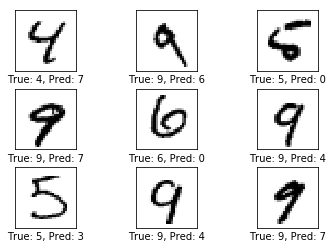

In [209]:
print_test_accuracy(show_example_errors=True)

In [210]:
### Performance after 10000 training iteration

In [211]:
optimize(num_iterations=9900) #we have already done 100 iterations

Optimization Iteration:    101, Training Accuracy:  50.0%
Optimization Iteration:    201, Training Accuracy:  68.8%
Optimization Iteration:    301, Training Accuracy:  84.4%
Optimization Iteration:    401, Training Accuracy:  82.8%
Optimization Iteration:    501, Training Accuracy:  95.3%
Optimization Iteration:    601, Training Accuracy:  98.4%
Optimization Iteration:    701, Training Accuracy:  89.1%
Optimization Iteration:    801, Training Accuracy:  87.5%
Optimization Iteration:    901, Training Accuracy:  92.2%
Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy:  87.5%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  98.4%
Optimization Iteration:   1501, Training Accuracy:  89.1%
Optimization Iteration:   1601, Training Accuracy:  93.8%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization I